In [122]:
# For suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')


# Importing required modules
import re
from string import punctuation
import numpy as np
import pandas as pd


# For NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# For ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

In [123]:
# Reading data from the file: "twitter_training.csv"
train_filename = "data/data/twitter_training.csv"
df_train = pd.read_csv(train_filename, names = ['id', 'game/company', 'label', 'tweet'])
df_train.head()

,id,game/company,label,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [166]:
# Reading data from the file: "twitter_validation.csv"
test_filename = "data/data/twitter_validation.csv"
df_test = pd.read_csv(test_filename, names = ['id', 'game/company', 'label', 'tweet'])
df_test.head()

,id,game/company,label,tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [167]:
print(df_train.shape)
print(df_test.shape)

(73996, 5)
(1000, 4)


In [126]:
# Describing the data
df_train.describe(include='object').T

,count,unique,top,freq
game/company,74682,32,Microsoft,2400
label,74682,4,Negative,22542
tweet,73996,69491,"At the same time, despite the fact that there ...",172


In [127]:
# Checking the datatypes
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            74682 non-null  int64 
 1   game/company  74682 non-null  object
 2   label         74682 non-null  object
 3   tweet         73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [128]:
df_train.isnull().sum()

id                0
game/company      0
label             0
tweet           686
dtype: int64

In [129]:
df_train[df_train['tweet'].isnull()]

,id,game/company,label,tweet
61,2411,Borderlands,Neutral,NaN
553,2496,Borderlands,Neutral,NaN
589,2503,Borderlands,Neutral,NaN
745,2532,Borderlands,Positive,NaN
1105,2595,Borderlands,Positive,NaN
...,...,...,...,...
73972,9073,Nvidia,Positive,NaN
73973,9073,Nvidia,Positive,NaN
74421,9154,Nvidia,Positive,NaN
74422,9154,Nvidia,Positive,NaN


In [130]:
# Dropping the rows with null tweets
df_train = df_train.dropna()
df_train.isnull().sum()

id              0
game/company    0
label           0
tweet           0
dtype: int64

In [131]:
print(df_test.describe(include='object').T)
print(df_test.info())

             count unique                     top freq
game/company  1000     32  RedDeadRedemption(RDR)   40
label         1000      4                 Neutral  285
tweet         1000    999                     Wow    2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1000 non-null   int64 
 1   game/company  1000 non-null   object
 2   label         1000 non-null   object
 3   tweet         1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None


In [168]:
df_test[df_test['tweet'].isnull()]

,id,game/company,label,tweet


In [133]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Tải tài nguyên nếu chưa có
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /home/thientran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/thientran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/thientran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/thientran/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/thientran/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/thientran/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [134]:
# Dictionary of common chat abbreviations and their full forms.
# This dictionary contains popular shorthand used in text messaging and online chatting.
# Each key is a chat abbreviation, and the corresponding value is the full phrase or meaning.
# Reference: https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt

CHAT_WORDS_MAP = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing",
    "L8": "Late",
    "SMH": "Shaking My Head",
    "YOLO": "You Only Live Once",
    "TLDR": "Too Long; Didn't Read",
    "FOMO": "Fear Of Missing Out",
    "IDK": "I Don't Know",
    "BFFL": "Best Friends For Life",
    "TMI": "Too Much Information",
    "DM": "Direct Message",
    "STFU": "Shut The F... Up",
    "WTH": "What The Heck",
    "LMAOROTF": "Laughing My A... Off Rolling On The Floor",
    "PPL": "People",
    "SFLR": "Sorry For Late Reply",
    "G2G": "Got To Go",
    "S2R": "Send To Receive"
}

emoji_pattern = (
        "[\U0001F600-\U0001F64F" # Emoticons
        "\U0001F300-\U0001F5FF"  # Miscellaneous Symbols and Pictographs
        "\U0001F680-\U0001F6FF"  # Transport and Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed characters
        "]+")
emoji_pattern = re.compile(
    "[\U0001F600-\U0001F64F"  # Emoticons
    "\U0001F300-\U0001F5FF"   # Misc Symbols and Pictographs
    "\U0001F680-\U0001F6FF"   # Transport & Map Symbols
    "\U0001F700-\U0001F77F"   # Alchemical Symbols
    "\U0001F780-\U0001F7FF"   # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"   # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"   # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"   # Chess Symbols
    "\U0001FA70-\U0001FAFF"   # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"   # Dingbats
    "\U000024C2-\U0001F251"   # Enclosed characters
    "]+", flags=re.UNICODE
)

In [135]:
def convert_to_lowercase(text):
    return text.lower()

def remove_html_tags(text):
    return re.sub(r'<.*?>', ' ', text)

def remove_urls(text):
    return re.sub(r"http\S+|www\S+", "", text)

# def remove_emojis(text):
#     return text.encode('ascii', 'ignore').decode('utf-8')
# Hàm xoá emoji
def remove_emojis(text):
    return emoji_pattern.sub(r'', text)

def apply_chat_word_map(text):
    return ' '.join([CHAT_WORDS_MAP.get(word, word) for word in text.split()])

def remove_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    return ' '.join([word for word in word_tokenize(text) if word.lower() not in stop_words])

def remove_extra_whitespaces(text):
    return re.sub(r'\s+', ' ', text).strip()
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return ' '.join([
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tags
    ])

In [136]:
def full_clean_pipeline(text):
    text = convert_to_lowercase(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_emojis(text)
    text = apply_chat_word_map(text)
    text = remove_punctuations(text)
    text = remove_stopwords(text)
    text = remove_extra_whitespaces(text)
    text = lemmatize_text(text)
    return text

In [137]:
df_train.head(10)
#Check data types of the columns
df_train.dtypes

# df_train['tweet_processed'] = df_train['tweet'].apply(full_clean_pipeline)
# Áp dụng pipeline xử lý text
df_train['cleaned_tweet'] = df_train['tweet'].apply(full_clean_pipeline)

df_train['cleaned_tweet'].head(10)



0                             im get borderland murder
1                                     come border kill
2                               im get borderland kill
3                            im come borderland murder
4                           im get borderland 2 murder
5                             im get borderland murder
6    spent hour make something fun dont know huge b...
7    spent couple hour something fun dont know im h...
8    spent hour something fun dont know im huge bor...
9    spent hour make something fun dont know huge r...
Name: cleaned_tweet, dtype: object

In [169]:
df_test['cleaned_tweet'] = df_test['tweet'].apply(full_clean_pipeline)
df_test['cleaned_tweet'].head(10)

0    mention facebook struggle motivation go run da...
1    bbc news amazon bos jeff bezos reject claim co...
2    microsoft pay word function poorly samsungus c...
3    csgo matchmaking full closet hack truly awful ...
4    president slap american face really commit unl...
5    hi eahelp ’ madeleine mccann cellar past 13 ye...
6    thank eamaddennfl new te austin hooper orange ...
7    rocket league sea thief rainbow six siege love...
8    as still kneedeep assassin creed odyssey way a...
9    fix jesus please fix world go playstation askp...
Name: cleaned_tweet, dtype: object

In [170]:
df_test.head(10)

,id,game/company,label,tweet,cleaned_tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,mention facebook struggle motivation go run da...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,bbc news amazon bos jeff bezos reject claim co...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,microsoft pay word function poorly samsungus c...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",csgo matchmaking full closet hack truly awful ...
4,4433,Google,Neutral,Now the President is slapping Americans in the...,president slap american face really commit unl...
5,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,hi eahelp ’ madeleine mccann cellar past 13 ye...
6,7925,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...,thank eamaddennfl new te austin hooper orange ...
7,11332,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ...",rocket league sea thief rainbow six siege love...
8,1107,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...,as still kneedeep assassin creed odyssey way a...
9,2069,CallOfDuty,Negative,FIX IT JESUS ! Please FIX IT ! What In the wor...,fix jesus please fix world go playstation askp...


In [140]:
df_train.head(10)


,id,game/company,label,tweet,cleaned_tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im get borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im get borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im come borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im get borderland 2 murder
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im get borderland murder
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...,spent hour make something fun dont know huge b...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...,spent couple hour something fun dont know im h...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...,spent hour something fun dont know im huge bor...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...,spent hour make something fun dont know huge r...


In [141]:
df = df_train[['cleaned_tweet', 'label']]
df.columns = ['text', 'label']
df.head(10)
#mapping labels to numbers 0 1 2 3 (negative, neutral, positive, Unre)
df['label'] = df['label'].map({'Negative': 0, 'Positive': 1, 'Neutral': 2, 'Irrelevant': 3})
df.head(10)
df['label'].value_counts()



label
0    22358
1    20655
2    18108
3    12875
Name: count, dtype: int64

In [171]:
df_test['cleaned_tweet'] = df_test['tweet'].apply(full_clean_pipeline)
df_test['cleaned_tweet'].head(10)
df_test = df_test[['cleaned_tweet', 'label']]

In [143]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [144]:
df.head(10)

,text,label
0,im get borderland murder,1
1,come border kill,1
2,im get borderland kill,1
3,im come borderland murder,1
4,im get borderland 2 murder,1
5,im get borderland murder,1
6,spent hour make something fun dont know huge b...,1
7,spent couple hour something fun dont know im h...,1
8,spent hour something fun dont know im huge bor...,1
9,spent hour make something fun dont know huge r...,1


In [145]:
# # Regex to finding emojis
# emoji_pattern = (
#         "[\U0001F600-\U0001F64F" # Emoticons
#         "\U0001F300-\U0001F5FF"  # Miscellaneous Symbols and Pictographs
#         "\U0001F680-\U0001F6FF"  # Transport and Map Symbols
#         "\U0001F700-\U0001F77F"  # Alchemical Symbols
#         "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
#         "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
#         "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
#         "\U0001FA00-\U0001FA6F"  # Chess Symbols
#         "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
#         "\U00002702-\U000027B0"  # Dingbats
#         "\U000024C2-\U0001F251"  # Enclosed characters
#         "]+")

# Checking if we have emojis in our dataset
df[df['text'].str.contains(emoji_pattern, regex = True)]['text']

Series([], Name: text, dtype: object)

In [173]:

df_test.head(10)
df_test['cleaned_tweet'] = df_test['cleaned_tweet'].apply(full_clean_pipeline)
df_test['cleaned_tweet'].head(10)
df_test = df_test[['cleaned_tweet', 'label']]
df_test.columns = ['text', 'label']
df_test['label'] = df_test['label'].map({'Negative': 0, 'Positive': 1, 'Neutral': 2, 'Irrelevant': 3})
df_test.head(10)
df_test['label'].value_counts()
df_test.isnull().sum()
df_test.head(10)

,text,label
0,mention facebook struggle motivation go run da...,3
1,bbc news amazon bos jeff bezos reject claim co...,2
2,microsoft pay word function poorly samsungus c...,0
3,csgo matchmaking full closet hack truly awful ...,0
4,president slap american face really commit unl...,2
5,hi eahelp ’ madeleine mccann cellar past 13 ye...,0
6,thank eamaddennfl new te austin hooper orange ...,1
7,rocket league sea thief rainbow six siege love...,1
8,still kneedeep assassin creed odyssey way anyt...,1
9,fix jesus please fix world go playstation askp...,0


In [174]:
df_test.columns = ['Text', 'Label']
df_test.head(10)

,Text,Label
0,mention facebook struggle motivation go run da...,3
1,bbc news amazon bos jeff bezos reject claim co...,2
2,microsoft pay word function poorly samsungus c...,0
3,csgo matchmaking full closet hack truly awful ...,0
4,president slap american face really commit unl...,2
5,hi eahelp ’ madeleine mccann cellar past 13 ye...,0
6,thank eamaddennfl new te austin hooper orange ...,1
7,rocket league sea thief rainbow six siege love...,1
8,still kneedeep assassin creed odyssey way anyt...,1
9,fix jesus please fix world go playstation askp...,0


text     0
label    0
dtype: int64


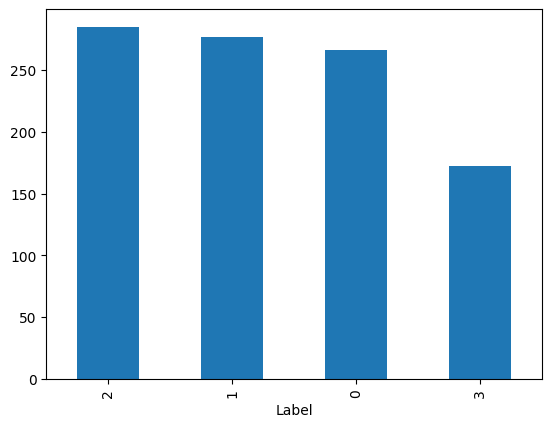

In [180]:
df_test['Label'].value_counts()
df_test['Label'].value_counts().plot(kind='bar')
# df_test.to_csv('twitter_validation_cleaned.csv', index=False)
# 2. Loại bỏ các dòng có nội dung quá ngắn (ví dụ < 5 ký tự sau khi strip)
df_test = df_test[df_test['Text'].str.strip().str.len() >= 3]

# 3. Drop những cột chứa toàn giá trị là số (chuỗi dạng '123', '45', ...)
for col in df.columns:
    if df[col].dtype == 'object':
        is_numeric_str = df[col].dropna().apply(lambda x: str(x).isdigit())
        if is_numeric_str.all():
            print(f"Dropping column (only numeric strings): {col}")
            df = df.drop(columns=[col])
            
# Kiểm tra lại sau khi xóa
print(df.isnull().sum())
df_test.to_csv('twitter_validation_cleaned.csv', index=False)

In [148]:
X_train = df['text']
y_train = df['label']
# X_test = df_test['text']
# y_test = df_test['label']

In [149]:
('TF-Idf_train', TfidfVectorizer())
#vectorizer X_train
vectorizer = TfidfVectorizer(
    # lowercase=True,
    # max_features=10000,
    # ngram_range=(1, 2),
    # stop_words='english'
)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [150]:
model = LogisticRegression(C = 10, solver='saga', max_iter=10000, random_state=101)
model.fit(X_train_vectorized, y_train)

LogisticRegression(C=10, max_iter=10000, random_state=101, solver='saga')

In [151]:
y_pred = model.predict(X_test_vectorized)

In [154]:
# Evaluating the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted')}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test_vectorized), average='weighted', multi_class='ovr')}")

Accuracy: 0.947
Precision: 0.9471503848326062
Recall: 0.947
F1-Score: 0.9469792990906335
ROC-AUC Score: 0.9913615618137084


In [ ]:
df.head(10)
df.count()

df.isnull().sum()
df.columns = ['Text', 'Label']
df['Label'].value_counts()
df.head(10)
print(df.isnull().sum())
# Xóa giá trị null theo từng cột
df = df.dropna(subset=['Text'])
df = df.dropna(subset=['Label'])

# 2. Loại bỏ các dòng có nội dung quá ngắn (ví dụ < 5 ký tự sau khi strip)
df = df[df['Text'].str.strip().str.len() >= 5]

# 3. Drop những cột chứa toàn giá trị là số (chuỗi dạng '123', '45', ...)
for col in df.columns:
    if df[col].dtype == 'object':
        is_numeric_str = df[col].dropna().apply(lambda x: str(x).isdigit())
        if is_numeric_str.all():
            print(f"Dropping column (only numeric strings): {col}")
            df = df.drop(columns=[col])
            
# Kiểm tra lại sau khi xóa
print(df.isnull().sum())
df.to_csv("twitter_training.csv", index=False) #Index


Text     0
Label    0
dtype: int64
Text     0
Label    0
dtype: int64


In [ ]:
df[df['Text'].str.contains('<.*?>')]
df[df['Text'].str.contains(r'https?://\S+|www\.\S+', regex = True)]['Text'].iloc[0]

IndexError: single positional indexer is out-of-bounds

In [ ]:
df = pd.read_csv(f'dataset_.csv')
df.head(10)


,Text,Label
0,1,im getting borderlands kill
1,1,im coming borderlands murder
2,1,im getting borderlands murder
3,1,im getting borderlands murder
4,1,spent hours making something fun dont know hug...
5,1,spent couple hours something fun dont know im ...
6,1,spent hours something fun dont know im huge bo...
7,1,spent hours making something fun dont know hug...
8,1,spent hours making something fun dont know hug...
9,2,rockhard la varlope rare powerful handsome jac...


In [ ]:
df.count()
df.isnull().sum()
df.columns = ['Label', 'Text']
df['Label'].value_counts()
df['Text'].value_counts()




Text
first time eu commission taken step                                                                                            172
time despite fact currently million people living poverty line access health services access health care access health care    172
wow                                                                                                                            162
wtf                                                                                                                            109
love                                                                                                                            78
                                                                                                                              ... 
completed assassins creed ezio colletction cant seem enjoy third game bitlyjstdu                                                 1
finished assassins credo ezio colletction seem enjoy third game bitly jstdu   

<Axes: xlabel='Label'>

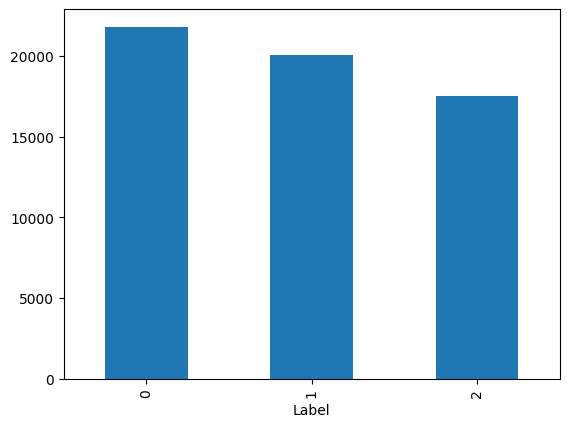

In [197]:
df = df[df['Label'] != 3]
df['Label'].value_counts()
df['Label'].value_counts().plot(kind='bar')


In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

X_train = tweet_processing_pipeline.fit_transform(X_train)
X_test = tweet_processing_pipeline.transform(X_test)
# Creating an instance of LogisticRegression and training it
model = LogisticRegression(C = 10, solver='saga', max_iter=10000, random_state=101)
model.fit(X_train, y_train)

